# Report for 2D Project Physical World and Digital World

Cohort: # enter your cohort

Team No.: # Enter your team number

Members:
* Student 1 Name (Student ID)
* Student 2 Name (Student ID)


# Introduction

Write your introduction here. Describe the problem you want to solve and a brief of your approach and summary of your result.


In [ ]:
"""
Our aim is to use the thermosensor given and test from 10 to 60 degree with a gap of 20. 
Using the model given to find out the best fit model for the temperature. 
The idea of the model is to get the the temperature of the first 10 seconds and predict out the final temperature. 
Using exponential function and linear regresssion.
"""

# Description of Data from Experiment

## Data Collection

Describe how you collect your data and the reasoning behind such approach.



In [ ]:
import pickle
import time
from w1thermsensor import W1ThermSensor
import os
# create one dict with two list inside to store the time and the temperature
d = {"time":[],"temperature":[]}
sensor = W1ThermSensor.get_available_sensors()[0]
start = time.time()
# measure the temperature for 120 times and store the temperature and the time when we measured it inside the dict
for i in range(120):
    temperature = sensor.get_temperature()
    d["time"].append(time.time() - start)
    d["temperature"].append(temperature)
    print("{0}Sensor has temperature {1}".format(i,temperature))
    time.sleep(1)
# naming the file using the time when we created the file
# and we record the time when we did the experiment and the exact temperature so that we know the exact temperature and the time wew did the experiment.
now = time.strftime('%Y-%m-%d-%H:%M:%S',time.localtime())
name = "{0}.pickle".format(now)
# create a file and name it using the time we created, and use pickle to store the data inside
os.system("touch {0}".format(name))
file = open(name,"wb")
pickle.dump(d,file)
file.close()

# this way is convinient and can directly store a dictionary into a file, and we can directly reload it the next time

## Data Preparation

Describe how you prepare your data. Include any codes you have here.

In [ ]:
"""
We extract out the data from the pickle file and store it inside the csv file
"""

In [1]:
import csv
import numpy as np
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

csvFile = open("data.csv", "r")
reader = csv.reader(csvFile)
# create a dict to store different groups of experiment respectively
result = {'time0': [], 'temperature0': [], 'time1': [], 'temperature1': [], 'time2': [], 'temperature2': [], 'time3': [], 
    'temperature3': [], 'time4': [], 'temperature4': [], 'time5': [], 'temperature5': [], 'time6': [], 'temperature6': []}
for item in reader:
    if reader.line_num == 1:
        l = item
    else:
        # put the value inside the dict with respect to their keys
        for i in range(14):
            result[l[i]].append(float(item[i]))
csvFile.close()

## Data Format

Describe your data and its features. Include any codes or visualization of data.

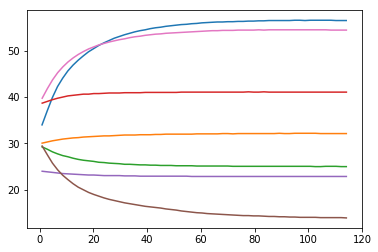

In [2]:
# plot out all the graphs
for i in range(7):
    plt.plot(result["time{0}".format(i)],result["temperature{0}".format(i)])

In [3]:
# extract out data of experiment 0
tem = np.array(result["temperature0"])
time = np.array(result["time0"])
def prepare(tem,time):
    # prepare data for train, we choose the one with the largest temperature gap
    # final temperature/water temperature, and add a small error to avoid ln(0) error
    t_w = tem[-1]+0.001 
    # initial value/environment temperature
    t0 = tem[0] 
    # use absolute value to avoid mistake 
    data = abs(tem - t_w) 
    t_diff = abs(t_w - t0)
    # reshape the data to a 2D array
    time = time.reshape((time.shape[0],1))
    data = data.reshape((time.shape[0],1))
    return t0,t_diff,data,time
t0,t_diff,data,time = prepare(np.array(result["temperature0"]),time = np.array(result["time0"]))
t01,t_diff1,data1,time1 = prepare(np.array(result["temperature1"]),time = np.array(result["time1"]))

In [4]:
def train_model(t0,t_diff,data,time,t01,t_diff1,data1,time1):
    # get the ln((tw - ts)/(tamb - tw))
    # as we supposed that tao did not change with temperature
    # so we form a linear model of ln((tw - ts)/(tamb - tw)) = - T/tao + c
    ln = np.log(data/t_diff)
    ln1 = np.log(data1/t_diff1)
    # here we define a as -1/tao, then use linear model to fit time and ln((tw - ts)/(tamb - tw))
    model = linear_model.LinearRegression().fit(time,ln)
    # make a prediction and estimate the mean square error and R2_score
    pred = model.predict(time1)
    MSE=mean_squared_error(ln1,pred)
    R2_score=r2_score(ln1,pred)
    return model,float(model.coef_),float(model.intercept_),MSE,R2_score
model,coef,intercept,MSE,R2_score = train_model(t0,t_diff,data,time,t01,t_diff1,data1,time1)
print("coef={0},intercept={1}".format(coef,intercept))
print("tao={0}".format(-1/coef))
print("mean square error={0},R2_error={1}".format(MSE,R2_score))

coef=-0.08104848751493608,intercept=0.4908115952542831
tao=12.338293170686427
mean square error=2.462101774874548,R2_error=0.659672319736316


In [5]:
"""after getting tao and the intercpt we use another linear model with respect to the exp of t 
to model it and predict the temperature after 100 seconds which is when the temperature stabelise"""
def predict(t,t0,k):
    # set the initial temperature, we take ret as initial value for predict
    ret = t0
    for i in range(100):
        # we estimate out the gap between the readings and add them up(integrate)
        ret += k * np.exp((100-t)*(coef)+intercept) * 105.1532
    return float(ret)

# Verification and Accuracy

Describe how you check the accuracy of your model and its result. State any analysis you have and the steps you have taken to improve its accuracy.

In [6]:
# get the second reading of every experiment and the time of this reading, 
# as well as the gap between the first reading and the second reading, store it inside test[]
# get the final reading of every experiment and store it inside actual[]
test = []
actual = []
for i in range(7):
    temperature = result["temperature{0}".format(i)]
    time = result["time{0}".format(i)]
    t = time[1]
    t0 = temperature[1]
    k = temperature[1]- temperature[0]
    test.append([t,t0,k])
    actual.append(temperature[-1])
# change test and actual to be numpy array
test = np.array(test)
actual = np.array(actual)

In [7]:
# find out the average error of the the predictions
def sum_error():
    sum = 0.0
    for i in range(7):
        pred = predict(test[i][0],test[i][1],test[i][2])
        error = abs(pred - actual[i])
        sum += error
    return sum
print("average_error={0}".format(sum_error()/7))

average_error=0.5065194282950396


# Example Scripts

Instruction:

* Read an excel file with the following format:
```
time (s)	reading
0.00	    25.812
0.90	    28.562
1.79	    31.875
2.68	    35.062
3.55	    37.937
4.43	    40.687
5.30	    43.25
```
where the first column indicates the time in seconds and the second column indicates the sensor reading in Celsius. 
* Write a code to prepare the data, extract the features.
* Write a code to split the data.
* Write a code to train the model.
* Write a code to predict the final temperature.
* Write a code to check accuracy.

**The script below is just for your example. You don't have to use it and you can write your own script.**

